<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/11.%20%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9%20%D0%9C%D0%9E/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%E2%84%9614_%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D1%80%D1%82%D1%8B%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%D0%9C%D0%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Теория №14. Развертывание моделей машинного обучения**

В данном учебном блокноте представлен полный жизненный цикл разработки моделей машинного обучения для задач регрессии и классификации. Начиная со сбора и подготовки данных, проводится обучение и оценка большинства основных моделей машинного обучения. Лучшая модель выбирается на основе вычисленных метрик качества. Далее модель сохраняется, развёртывается на сервере и разрабатывается интерфейс для взаимодействия с ней. Этот процесс охватывает все этапы жизненного цикла модели машинного обучения: от предварительной обработки данных до интеграции модели в приложение и её развёртывания на сервере.

# **I. Решение задачи регрессии на примере датасета California Housing**

## **1. Установка необходимых зависимостей**

In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Модели регрессии
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet,
                                  BayesianRidge, SGDRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor, HistGradientBoostingRegressor,
                              AdaBoostRegressor, BaggingRegressor)
from sklearn.neural_network import MLPRegressor

import pickle

## **2. Загрузка набора данных. Формирование обучающей и тестовой выборок**

In [ ]:
data = fetch_california_housing(as_frame=True)
df = data.frame
X = df.drop(columns=[data.target_names[0]])
y = df[data.target_names[0]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X_train.iloc[0]

,14196
MedInc,3.259600
HouseAge,33.000000
AveRooms,5.017657
AveBedrms,1.006421
Population,2300.000000
AveOccup,3.691814
Latitude,32.710000
Longitude,-117.030000


## **3. Инициализация метрик для оценки качества обучения моделей**

In [ ]:
def mean_squared_percentage_error(y_true, y_pred):
    # MSPE
    return np.mean((y_true - y_pred) ** 2 / (y_true + 1e-9) ** 2) * 100

def mean_absolute_percentage_error(y_true, y_pred):
    # MAPE
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    # SMAPE
    return 100 * np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
    )

def mean_relative_error(y_true, y_pred):
    # MRE
    return np.mean(np.abs(y_true - y_pred) / (y_true + 1e-9))

def rmsle(y_true, y_pred):
    # RMSLE
    return np.sqrt(np.mean((np.log1p(y_pred + 1e-9) - np.log1p(y_true + 1e-9))**2))

def adjusted_r2_score(r2, n, p):
    """
    Расчёт скорректированного R².
    r2:   R²
    n:    число наблюдений
    p:    число признаков
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def get_metrics(y_true, y_pred, n, p):
    # MAE
    mae_ = mean_absolute_error(y_true, y_pred)
    # MSE
    mse_ = mean_squared_error(y_true, y_pred)
    # RMSE
    rmse_ = np.sqrt(mse_)
    # R^2
    r2_ = r2_score(y_true, y_pred)
    # MAPE
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    # MSPE
    mspe_ = mean_squared_percentage_error(y_true, y_pred)
    # SMAPE
    smape_ = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    # MRE
    mre_ = mean_relative_error(y_true, y_pred)
    # RMSLE
    rmsle_ = rmsle(y_true, y_pred)
    # Adjusted R²
    adj_r2_ = adjusted_r2_score(r2_, n, p)
    return {
        "MAE": mae_,
        "MAPE": mape_,
        "MSE": mse_,
        "RMSE": rmse_,
        "R2": r2_,
        "MSPE": mspe_,
        "SMAPE": smape_,
        "MRE": mre_,
        "RMSLE": rmsle_,
        "Adjusted R2": adj_r2_
    }

## **4. Инициализация моделей машинного обучения для решения задачи регрессии из sklearn**

In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "SVR": SVR(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "BaggingRegressor": BaggingRegressor(random_state=42),
    "MLPRegressor": MLPRegressor(max_iter=500, random_state=42),
}

## **5. Формирование пайплана, включающего в себя стандартизацию и формирование дополнительных полиноминальных признаков**

In [ ]:
feature_engineering = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])

# Преобразуем данные
X_train_transformed = feature_engineering.fit_transform(X_train)
X_test_transformed = feature_engineering.transform(X_test)

n_train, n_features = X_train_transformed.shape

## **6. Обучение моделей машинного обучения с вычислением метрик**

In [ ]:
results = {}
for name, model in models.items():
    # Обучаем
    model.fit(X_train_transformed, y_train)
    # Предсказания
    y_pred = model.predict(X_test_transformed)
    # Подсчёт метрик
    metrics = get_metrics(y_test, y_pred, n=len(y_test), p=n_features)
    results[name] = metrics

## **7. Оценка точности и выбор лучшей модели**

In [ ]:
results_df = pd.DataFrame(results).T  # Переводим в DataFrame для удобства
results_df = results_df.sort_values(by='R2', ascending=False)

print("Результаты по всем моделям:\n")
display(results_df.style.format("{:.3f}"))

# Можно определить лучшую модель, например, по наибольшему R2 (или Adjusted R2).
best_model_name = results_df["R2"].idxmax()
print(f"\nЛучшая модель по R2: {best_model_name}")
best_model = models[best_model_name]

Результаты по всем моделям:



,MAE,MAPE,MSE,RMSE,R2,MSPE,SMAPE,MRE,RMSLE,Adjusted R2
HistGradientBoostingRegressor,0.313,18.213,0.218,0.467,0.834,17.714,16.328,0.182,0.143,0.832
ExtraTreesRegressor,0.329,18.716,0.255,0.505,0.805,20.831,16.461,0.187,0.149,0.803
RandomForestRegressor,0.333,19.172,0.262,0.512,0.800,21.317,16.785,0.192,0.152,0.798
GradientBoostingRegressor,0.363,21.125,0.284,0.533,0.783,21.191,18.872,0.211,0.162,0.781
BaggingRegressor,0.354,20.268,0.289,0.538,0.779,24.520,17.761,0.203,0.160,0.777
KNeighborsRegressor,0.450,24.914,0.443,0.666,0.662,30.127,22.188,0.249,0.196,0.658
BayesianRidge,0.467,26.906,0.462,0.679,0.648,25.681,24.100,0.269,0.200,0.644
Ridge,0.467,26.903,0.463,0.680,0.647,25.718,24.098,0.269,0.200,0.643
LinearRegression,0.467,26.899,0.464,0.681,0.646,25.770,24.096,0.269,0.200,0.642
DecisionTreeRegressor,0.449,24.605,0.493,0.702,0.624,22.950,22.258,0.246,0.207,0.620



Лучшая модель по R2: HistGradientBoostingRegressor


## **8. Сохранение лучшей модели**

In [ ]:
with open("best_regression_model.pkl", "wb") as f:
    pickle.dump({
        "pipeline": feature_engineering,
        "model": best_model
    }, f)

print("\nЛучшая модель сохранена в файл best_regression_model.pkl")

## **9. Загрузка и использование лучшей модели**

In [ ]:
import pickle
import numpy as np

# Загрузка
with open("best_regression_model.pkl", "rb") as f:
    saved_objects = pickle.load(f)
loaded_feature_engineering = saved_objects["pipeline"]
loaded_model = saved_objects["model"]

# Пример использования (предположим, есть новый X_new)
X_new = np.array([[8.0, 20.0, 6.0, 1.0, 1000.0, 3.0, 34.19, -118.31]])  # Пример вектора признаков
# Преобразуем по тем же шагам, что и при обучении
X_new_transformed = loaded_feature_engineering.transform(X_new)
# Предсказываем
prediction = loaded_model.predict(X_new_transformed)
print("Предсказание цены:", prediction)

Предсказание цены: [3.7643755]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **10. Реализация веб-приложения с использованием Gradio, для работы с моделью**

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import pickle
import numpy as np

# 1. Загрузка объектов из файла Pickle
with open("best_regression_model.pkl", "rb") as f:
    saved_objects = pickle.load(f)

loaded_feature_engineering = saved_objects["pipeline"]
loaded_model = saved_objects["model"]

# 2. Функция предсказания
def predict_price(
    area,
    rooms,
    floor,
    total_floors,
    kitchen_area,
    distance_to_center,
    latitude,
    longitude
):
    """
    Функция принимает значения признаков, совершает
    те же преобразования, что при обучении, и возвращает предсказание.
    """
    # Формируем numpy-массив из входных данных
    X_new = np.array([[area, rooms, floor, total_floors,
                       kitchen_area, distance_to_center, latitude, longitude]])

    # Проводим те же преобразования, что и при обучении
    X_transformed = loaded_feature_engineering.transform(X_new)
    # Вызываем предикт у модели
    prediction = loaded_model.predict(X_transformed)

    return float(prediction[0])

# 3. Создаём интерфейс Gradio
interface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="area (общая площадь)"),
        gr.Number(label="rooms (количество комнат)"),
        gr.Number(label="floor (этаж)"),
        gr.Number(label="total_floors (всего этажей в доме)"),
        gr.Number(label="kitchen_area (площадь кухни)"),
        gr.Number(label="distance_to_center (Расстояние до центра)"),
        gr.Number(label="latitude (широта)"),
        gr.Number(label="longitude (долгота)")
    ],
    outputs="text",
    title="Прогноз стоимости недвижимости",
    description=(
        "Введите параметры (числа), затем нажмите 'Submit'. "
        "Модель вернёт предсказанную стоимость."
    )
)

# 4. Запуск интерфейса Gradio
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a65c1555f2d31b5aa5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **11. Реализация web-приложения, с использованием библиотеки Streamlit**

**(Весь процесс от начала и до конца рассматривался на паре, ниже привожу его структурированный пересказ)**

Разработка веб-приложения, которое служит интерфейсом для обученной модели, включает несколько этапов:

1. **Создание API для модели и развёртывание его на Render.com**
2. **Разработка графического интерфейса с использованием Streamlit**
3. **Развёртывание Streamlit приложения на платформе Streamlit**

Все этапы проводятся в десткопной среде Pycharm/VS Code, затем готовый проект пушится на GitHub

- Ссылка на репозиторий с приложением, которое было реализовано на паре: https://github.com/Alexandre77777/california_regression.git

#### **1. Создание API для модели и развёртывание его на Render.com**



**Файл `main.py`**

```python
from fastapi import FastAPI
import pickle
import numpy as np
from pydantic import BaseModel

app = FastAPI()
```

- **Импорт необходимых библиотек:**
  - `FastAPI` для создания веб-приложения API.
  - `pickle` для загрузки сохранённой модели.
  - `numpy` для работы с числовыми массивами.
  - `pydantic` для валидации входных данных.

- **Инициализация приложения:** Создаём экземпляр приложения `FastAPI`.

```python
class InputData(BaseModel):
    MedInc: float
    HouseAge: float
    AveRooms: float
    AveBedrms: float
    Population: float
    AveOccup: float
    Latitude: float
    Longitude: float
```

- **Определение модели входных данных:**
  - Создаём класс `InputData`, наследующий от `BaseModel`, который описывает структуру ожидаемых данных от клиента.
  - Каждый атрибут соответствует одному из признаков модели и имеет тип `float`.

```python
with open('best_regression_model.pkl', 'rb') as f:
    saved_objects = pickle.load(f)

loaded_feature_engineering = saved_objects["pipeline"]
loaded_model = saved_objects["model"]
```

- **Загрузка обученной модели и пайплайна предобработки:**
  - Открываем файл `best_regression_model.pkl`, который содержит сериализованные объекты.
  - Используем `pickle.load` для загрузки объектов в переменную `saved_objects`.
  - Извлекаем из неё пайплайн предобработки `loaded_feature_engineering` и саму модель `loaded_model`.

```python
@app.post('/predict')
async def predict(input_data: InputData):
    X_new = np.array([[
        input_data.MedInc,
        input_data.HouseAge,
        input_data.AveRooms,
        input_data.AveBedrms,
        input_data.Population,
        input_data.AveOccup,
        input_data.Latitude,
        input_data.Longitude
    ]])
```

- **Создание маршрута для предсказаний:**
  - Используем декоратор `@app.post('/predict')` для создания эндпоинта `/predict`, который будет обрабатывать POST-запросы.
  - Функция `predict` принимает объект `input_data` типа `InputData`.
  - Собираем входные данные в numpy-массив `X_new`, который затем подаётся на вход модели.

```python
    X_new_transformed = loaded_feature_engineering.transform(X_new)
```

- **Предобработка данных:**
  - Применяем пайплайн предобработки к входным данным, чтобы привести их к формату, ожидаемому моделью.

```python
    prediction = loaded_model.predict(X_new_transformed)
```

- **Получение прогноза:**
  - Используем загруженную модель для предсказания цены на основе предобработанных данных.

```python
    return {"prediction": float(prediction[0])}
```

- **Возвращение результата:**
  - Возвращаем прогноз в формате JSON, преобразуя результат в `float` для обеспечения сериализации.

**Файл `requirements.txt`**

```
fastapi==0.103.0
numpy
scikit-learn==1.6.0
uvicorn==0.23.2
streamlit
```

- **Зависимости проекта:**
  - Указываем необходимые библиотеки и их версии для корректной работы приложения.

**Развёртывание на Render.com**

1. **Регистрация и настройка проекта:**
   - Зарегистрироваться на [Render.com](https://render.com).
   - Создать новый веб-сервис, указав репозиторий с вашим проектом.
   - Указать ветку и команду запуска (например, `uvicorn main:app --host 0.0.0.0 --port 8000`).

2. **Настройка зависимостей:**
   - Render.com автоматически установит зависимости из файла `requirements.txt`.

3. **Развёртывание:**
   - Запустить процесс развёртывания и дождаться его завершения.

Теперь API доступен по адресу, предоставленному Render.com.

- Пример использования API:

In [ ]:
import requests

# URL API
url = 'https://california-regression.onrender.com/predict'

# Сбор данных от пользователя
print("Введите параметры для прогноза цены на жильё.")

MedInc = float(input("Медианный доход: "))
HouseAge = float(input("Средний возраст жилья: "))
AveRooms = float(input("Общее кол-во комнат: "))
AveBedrms = float(input("Общее кол-во спален: "))
Population = float(input("Население: "))
AveOccup = float(input("Кол-во домохозяйств: "))
Latitude = float(input("Широта: "))
Longitude = float(input("Долгота: "))

# Создание словаря с данными
data = {
    "MedInc": MedInc,
    "HouseAge": HouseAge,
    "AveRooms": AveRooms,
    "AveBedrms": AveBedrms,
    "Population": Population,
    "AveOccup": AveOccup,
    "Latitude": Latitude,
    "Longitude": Longitude
}

# Отправка POST-запроса к API
response = requests.post(url, json=data)

# Обработка ответа
if response.status_code == 200:
    try:
        result = response.json()
        prediction = result.get('prediction')
        if prediction is not None:
            print(f'Прогнозируемая цена: {prediction*1000:.2f}$')
        else:
            print("Ошибка! Ответ API не содержит прогноз!")
    except ValueError:
        print("Ошибка! Ответ API не является валидным JSON!")
else:
    print(f"Ошибка! API вернул статус: {response.status_code}")

Введите параметры для прогноза цены на жильё.
Медианный доход: 34
Средний возраст жилья: 3
Общее кол-во комнат: 4
Общее кол-во спален: 2
Население: 30000
Кол-во домохозяйств: 12
Широта: 54
Долгота: 36
Прогнозируемая цена: 3571.65$


### **2. Разработка графического интерфейса с использованием Streamlit**

**Файл `app.py`**

```python
import streamlit as st
import requests

st.title("Прогноз цены на жильё")
```

- **Импорт библиотек:**
  - `streamlit` для создания веб-приложения.
  - `requests` для отправки HTTP-запросов к API.

- **Заголовок приложения:**
  - С помощью `st.title` отображаем заголовок на странице.

```python
MedInc = st.number_input("Медианный доход", value=3.0)
HouseAge = st.number_input("Средний возраст жилья", value=3.0)
AveRooms = st.number_input("Общее кол-во комнат", value=3.0)
AveBedrms = st.number_input("Общее кол-во спален", value=3.0)
Population = st.number_input("Население", value=1500.0)
AveOccup = st.number_input("Кол-во домохозяйств", value=500.0)
Latitude = st.number_input("Широта", value=37.88)
Longitude = st.number_input("Долгота", value=-122.33)
```

- **Ввод данных пользователем:**
  - Используем `st.number_input` для создания полей ввода числовых данных.
  - Указываем метку и значение по умолчанию для каждого поля.

```python
if st.button("Получить прогноз"):
    data = {
        "MedInc": MedInc,
        "HouseAge": HouseAge,
        "AveRooms": AveRooms,
        "AveBedrms": AveBedrms,
        "Population": Population,
        "AveOccup": AveOccup,
        "Latitude": Latitude,
        "Longitude": Longitude
    }
```

- **Обработка события нажатия кнопки:**
  - С помощью `st.button` создаём кнопку "Получить прогноз".
  - При нажатии собираем введённые пользователем данные в словарь `data`.

```python
    url = 'https://california-regression.onrender.com/predict'
    response = requests.post(url, json=data)
```

- **Отправка запроса к API:**
  - Указываем URL ранее развёрнутого API.
  - С помощью `requests.post` отправляем POST-запрос с данными в формате JSON.

```python
    if response.status_code == 200:
        try:
            data = response.json()
            prediction = data.get('prediction')
            if prediction is not None:
                st.success(f'Прогнозируемая цена: {prediction*1000:.2f}$')
                st.subheader('Визуализация прогноза')
                st.bar_chart({"Прогноз": [prediction]})
            else:
                st.error("Ошибка! Ответ API не содержит прогноз!")
        except:
            st.error("Ошибка! Ответ API не является валидным JSON!")
    else:
        st.error(f"Ошибка! API вернул статус: {response.status_code}")
```

- **Обработка ответа от API:**
  - Проверяем статус ответа. Если он равен 200, значит запрос успешен.
  - Пробуем преобразовать ответ в JSON и получить значение `prediction`.
  - Если прогноз получен, отображаем его с помощью `st.success`, умножая на 1000 для получения цены в долларах.
  - Отображаем визуализацию прогноза с помощью `st.bar_chart`.
  - Если возникла ошибка, отображаем соответствующее сообщение.

### **3. Развёртывание Streamlit приложения на платформе Streamlit**



1. **Регистрация на Streamlit Sharing:**
   - Перейдите на [streamlit.io](https://streamlit.io) и зарегистрируйтесь.
   - Получите доступ к Streamlit Community Cloud (ранее Streamlit Sharing).

2. **Развёртывание приложения:**
   - На панели управления Streamlit создайте новое приложение, указав ссылку на ваш репозиторий и путь к файлу `app.py`.
   - Убедитесь, что в `requirements.txt` указаны все необходимые зависимости.

3. **Запуск и тестирование:**
   - Запустите приложение и убедитесь, что оно корректно работает.
   - Проверьте ввод данных и получение прогноза.

- Ссылка на развернутое приложение, реализованное на паре: https://californiaregression-kfbybrncfrpkju36p9kwn4.streamlit.app/

### **Структура репозитория с проектом**



```
app.py
best_regression_model.pkl
main.py
requirements.txt
```

- **`app.py`** — код Streamlit приложения (клиентская часть).
- **`main.py`** — код FastAPI приложения (серверная часть).
- **`best_regression_model.pkl`** — файл с сохранённой моделью и пайплайном предобработки.
- **`requirements.txt`** — список зависимостей для установки необходимых библиотек.

### **Выводы:**



В результате мы разработали веб-приложение, которое позволяет пользователю вводить параметры жилья и получать прогнозируемую цену. Процесс разработки включал:

- **Создание API с использованием FastAPI:** Мы создали серверное приложение, которое загружает обученную модель, принимает входные данные и возвращает предсказание.

- **Развёртывание API на Render.com:** Это позволяет сделать наш API доступным из интернета, чтобы клиентское приложение могло отправлять к нему запросы.

- **Разработка клиентского приложения с использованием Streamlit:** Мы создали удобный графический интерфейс, где пользователь может вводить данные и получать результаты.

- **Развёртывание Streamlit приложения:** Это делает наше приложение доступным для конечных пользователей через веб-браузер.

# **II. Классификация изображений**

## **1. Установка необходимых зависимостей**

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pickle

import tensorflow_datasets as tfds

## **2. Загрузка набора данных. Формирование обучающей и тестовой выборок**

In [ ]:
# Загрузка датасета EuroSAT
dataset, info = tfds.load(
    'eurosat',
    split='train',
    with_info=True,
    as_supervised=True
)

# Преобразование датасета в numpy массивы
all_images, all_labels = zip(*[(image.numpy(), label.numpy()) for image, label in dataset])
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split

# Загрузка датасета MNIST
dataset, info = tfds.load(
    'mnist',
    split='train',
    with_info=True,
    as_supervised=True
)

# Преобразование датасета в numpy массивы
all_images, all_labels = zip(*[(image.numpy(), label.numpy()) for image, label in dataset])
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Разделение данных на обучающую и тестовую выборки
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

## **5. Формирование пайплана, включающего в себя стандартизацию и формирование дополнительных полиноминальных признаков**

In [ ]:
from skimage.feature import hog
import numpy as np

def extract_features(images):
    features = []
    for img in images:
        # Преобразование изображения в оттенки серого, если оно цветное
        if len(img.shape) == 3:
            img_gray = np.mean(img, axis=2)
            channel_axis = None  # Для изображения в оттенках серого
        else:
            img_gray = img
            channel_axis = None  # Для изображения в оттенках серого

        # Вычисление HOG-дескриптора
        hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False, channel_axis=channel_axis)

        features.append(hog_features)

    return np.array(features)

X_train = extract_features(train_images)
X_test = extract_features(test_images)
y_train = train_labels
y_test = test_labels

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **4. Инициализация моделей машинного обучения для решения задачи классификации из sklearn**

In [ ]:
# Список моделей для обучения
models = [
    ('Logistic Regression', LogisticRegression(max_iter=5, solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB())
]

## **6. Обучение моделей машинного обучения с вычислением метрик**

In [ ]:
import time

# Обучение и оценка моделей
results = {}
for name, model in models:
    print(f"Начало обучения модели: {name}")
    start_time = time.time()

    model.fit(X_train_scaled, y_train)

    end_time = time.time()
    training_time = end_time - start_time

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

    results[name] = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': cm,
        'auc_roc': auc_roc,
        'training_time': training_time
    }

    print(f"Модель {name} обучена. Время обучения: {training_time:.2f} секунд")
    print()

Начало обучения модели: Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Модель Logistic Regression обучена. Время обучения: 6.45 секунд

Начало обучения модели: Decision Tree
Модель Decision Tree обучена. Время обучения: 23.59 секунд

Начало обучения модели: Random Forest
Модель Random Forest обучена. Время обучения: 80.24 секунд

Начало обучения модели: SVM
Модель SVM обучена. Время обучения: 290.49 секунд

Начало обучения модели: KNN
Модель KNN обучена. Время обучения: 0.01 секунд

Начало обучения модели: Naive Bayes
Модель Naive Bayes обучена. Время обучения: 0.21 секунд



## **7. Оценка точности и выбор лучшей модели**

,accuracy,recall,precision,f1,confusion_matrix,auc_roc,training_time
SVM,0.97225,0.97225,0.972275,0.972237,"[[1183, 2, 1, 0, 1, 0, 9, 1, 3, 0], [0, 1295, ...",0.999262,290.494035
Random Forest,0.952,0.952,0.951969,0.951965,"[[1177, 6, 1, 1, 2, 2, 6, 2, 2, 1], [0, 1282, ...",0.997874,80.237773
KNN,0.946417,0.946417,0.947413,0.946434,"[[1178, 6, 1, 1, 1, 0, 10, 0, 1, 2], [2, 1290,...",0.990394,0.013242
Logistic Regression,0.896417,0.896417,0.896232,0.895839,"[[1153, 11, 1, 1, 2, 2, 19, 6, 2, 3], [0, 1285...",0.989222,6.447915
Decision Tree,0.82975,0.82975,0.8298,0.82973,"[[1051, 5, 14, 19, 24, 16, 23, 7, 20, 21], [8,...",0.90547,23.590496
Naive Bayes,0.827583,0.827583,0.837727,0.827738,"[[1057, 36, 14, 9, 4, 29, 30, 1, 14, 6], [1, 1...",0.979083,0.209226


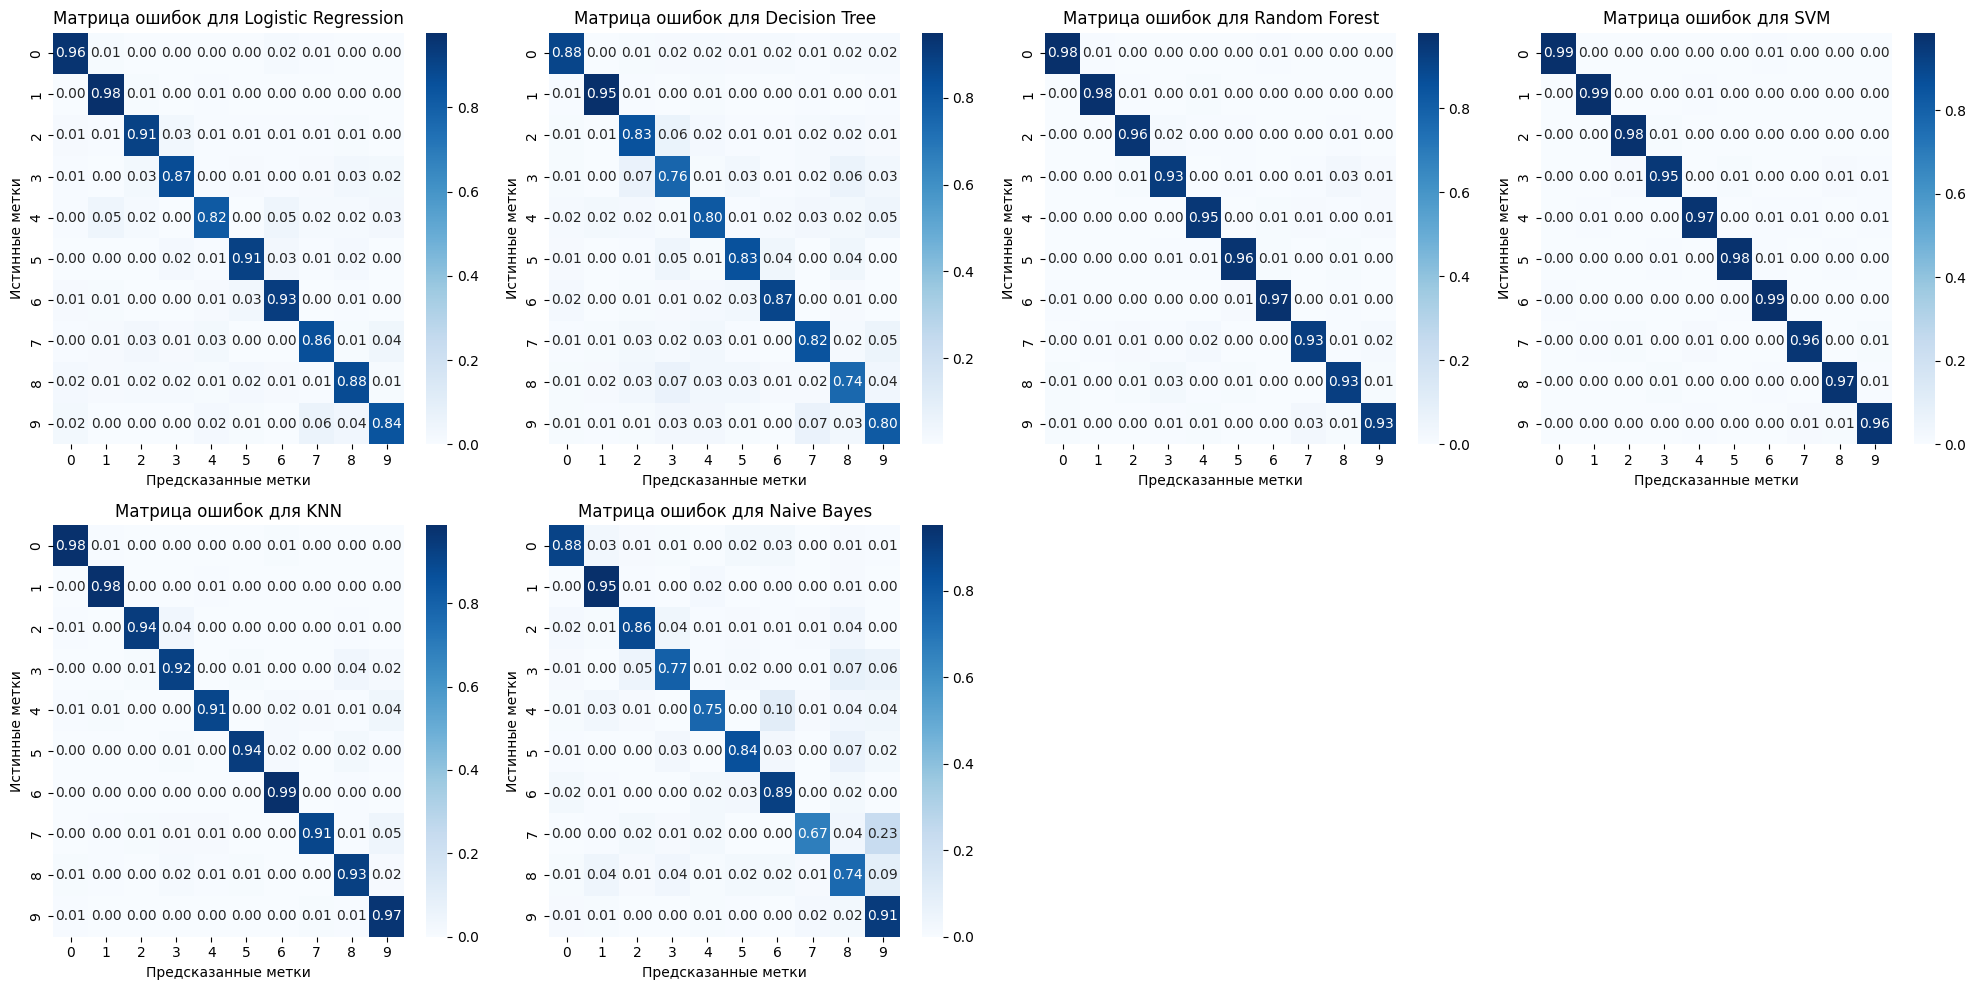

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

# Создание датафрейма с результатами
df_results = pd.DataFrame(results).T

# Сортировка датафрейма по F1-мере в убывающем порядке
df_results_sorted = df_results.sort_values('f1', ascending=False)

# Вывод отсортированного датафрейма
display(df_results_sorted)

# Создание сгруппированного изображения нормализованных матриц ошибок
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()  # Преобразование 2D массива в 1D

for i, (name, metrics) in enumerate(results.items()):
    cm = metrics['confusion_matrix']
    # Нормализация матрицы ошибок по строкам
    cm_normalized = normalize(cm, axis=1, norm='l1')

    ax = axes[i]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title(f'Матрица ошибок для {name}')
    ax.set_xlabel('Предсказанные метки')
    ax.set_ylabel('Истинные метки')

# Отключение лишних подграфиков
for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Выбор лучшей модели по F1-мере
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = models[[i for i, (name, _) in enumerate(models) if name == best_model_name][0]][1]

## **8. Сохранение лучшей модели**

In [ ]:
# Сохранение лучшей модели
with open('best_classification_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Сохранение scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"Лучшая модель: {best_model_name}")

Лучшая модель: SVM


## **9. Загрузка и использование лучшей модели**

In [ ]:
# Пример загрузки и использования модели
with open('best_classification_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Пример использования загруженной модели
sample_image = test_images[0]  # Пример изображения из тестового набора
sample_features = extract_features([sample_image])
sample_features_scaled = scaler.transform(sample_features)

prediction = loaded_model.predict(sample_features_scaled)
print(f"Предсказание для примера: {prediction}")

Предсказание для примера: [0]


## **10. Реализация веб-приложения с использованием Gradio, для работы с моделью**

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.transform import resize
from PIL import Image
import tensorflow as tf

# Загрузка модели и скалера
with open('best_classification_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Функция для извлечения признаков из изображения
def extract_features(images):
    features = []
    for img in images:
        # Изменение размера изображения до 28x28 (размер MNIST)
        img_resized = resize(img, (28, 28), anti_aliasing=True)

        # Преобразование изображения в оттенки серого
        if len(img_resized.shape) == 3:
            img_gray = np.mean(img_resized, axis=2)
        else:
            img_gray = img_resized

        # Вычисление HOG-дескриптора
        hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False)

        features.append(hog_features)

    return np.array(features)

# Функция для предсказания
def predict(image):
    features = extract_features([image])
    features_scaled = scaler.transform(features)
    prediction = loaded_model.predict(features_scaled)
    return f"Предсказанный класс: {prediction[0]}"

# Загрузка данных MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()

# Преобразование изображений MNIST в формат, совместимый с Gradio
mnist_examples = []
for i in range(3):  # Выбираем 3 примера
    img = train_images[i]
    mnist_examples.append([img])

# Создание интерфейса Gradio
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Классификация изображений MNIST",
    description="Загрузите изображение MNIST для классификации.",
    examples=mnist_examples
)

# Запуск интерфейса
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7b37079d52b287a1f0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **11. Реализация web-приложения, с использованием библиотеки Streamlit**

**(Происходит по аналогии с предыдущим разделом, ниже приведен пример кода основных элементов кода, для того чтобы показать как работать конкретно с изображениями)**

**Разработка веб-приложения для классификации изображений с использованием обученной модели**

Процесс разработки веб-приложения, которое будет являться интерфейсом для обученной модели классификации изображений, включает в себя несколько этапов:

1. **Разработка и развёртывание API на платформе Render.com**
2. **Создание графического интерфейса с использованием Streamlit**
3. **Развёртывание приложения Streamlit на платформе Streamlit**

Рассмотрим каждый из этих этапов, а также прокомментируем предоставленный код модулей `app.py` и `main.py`.

Все этапы проводятся в десткопной среде Pycharm/VS Code, затем готовый проект пушится на GitHub

- Ссылка на репозиторий с приложением для классификации: https://github.com/Alexandre77777/mnist_classification.git

### **1. Разработка и развёртывание API на платформе Render.com**



**Файл `main.py`**

```python
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
import numpy as np
from PIL import Image
import pickle
from skimage.feature import hog
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from io import BytesIO

app = FastAPI()

# Загрузка модели и scaler
with open('best_classification_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
```

**Объяснение:**

- **Импорт необходимых модулей:**
  - `FastAPI` для создания веб-приложения API.
  - `File`, `UploadFile`, `HTTPException` из `fastapi` для работы с загрузкой файлов и обработкой исключений.
  - `JSONResponse` для формирования JSON-ответов.
  - `numpy` для работы с массивами чисел.
  - `PIL.Image` для обработки изображений.
  - `pickle` для загрузки сохранённой модели и масштабатора (scaler).
  - `hog` и `resize` из `skimage` для извлечения признаков из изображений.
  - `StandardScaler` из `sklearn.preprocessing` для масштабирования признаков.
  - `BytesIO` из `io` для работы с байтовыми потоками.

- **Создание экземпляра приложения:**
  - `app = FastAPI()` создаёт экземпляр приложения FastAPI.

- **Загрузка модели и масштабатора:**
  - Сохраняем обученную модель классификации в файле `best_classification_model.pkl`. Этот файл содержит сериализованный объект модели.
  - Загружаем модель в переменную `model` с помощью `pickle.load(f)`.
  - Аналогично загружаем объект `scaler`, который используется для предварительной обработки признаков, из файла `scaler.pkl`.

```python
def extract_features(image):
    # Изменение размера изображения до 28x28 (размер MNIST)
    img_resized = resize(image, (28, 28), anti_aliasing=True)
    
    # Преобразование изображения в оттенки серого
    if len(img_resized.shape) == 3:
        img_gray = np.mean(img_resized, axis=2)
    else:
        img_gray = img_resized
    
    # Вычисление HOG-дескриптора
    hog_features = hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False
    )
    
    return hog_features
```

**Объяснение:**

- **Функция `extract_features`:**
  - **Цель:** Извлечь численные признаки из изображения для подачи в модель.
  
  - **Изменение размера изображения:**
    - `img_resized = resize(image, (28, 28), anti_aliasing=True)` — уменьшает размер изображения до 28x28 пикселей для стандартизации входных данных.
  
  - **Преобразование в оттенки серого:**
    - Проверяем, является ли изображение цветным (три канала). Если да, то преобразуем его в оттенки серого, усредняя значения по каналам.
    - Если изображение уже в оттенках серого, оставляем без изменений.
  
  - **Вычисление HOG-дескриптора:**
    - Используем функцию `hog` для получения признаков изображения на основе гистограммы ориентированных градиентов.
    - Параметры HOG-дескриптора настроены для оптимального извлечения признаков в данном контексте.
  
  - **Возвращаемые значения:**
    - Функция возвращает одномерный массив признаков `hog_features`, который будет использоваться для классификации.

```python
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # Чтение исходных байтов файла
    contents = await file.read()
        
    # Открываем изображение через BytesIO
    image = Image.open(BytesIO(contents))
    
    # Извлечение признаков
    features = extract_features(np.array(image))
    
    # Масштабирование признаков
    features_scaled = scaler.transform([features])
    
    # Предсказание
    prediction = model.predict(features_scaled)
    
    return JSONResponse(content={"prediction": int(prediction[0])})
```

**Объяснение:**

- **Создание эндпоинта `/predict/`:**
  - Декоратор `@app.post("/predict/")` указывает на обработку POST-запросов по указанному адресу.
  - Функция `predict` ожидает получения файла `file` из запроса.

- **Обработка загруженного файла:**
  - Читаем содержимое загруженного файла с помощью `await file.read()`.
  - Открываем изображение, используя `Image.open(BytesIO(contents))`, где `BytesIO` позволяет работать с байтовыми данными как с файловым объектом.

- **Извлечение признаков:**
  - Преобразуем изображение в массив NumPy для удобства обработки.
  - Вызываем функцию `extract_features` для получения признаков изображения.

- **Масштабирование признаков:**
  - Применяем загруженный ранее `scaler` для масштабирования признаков, что необходимо для корректной работы модели.

- **Получение предсказания:**
  - Подаём масштабированные признаки в модель и получаем предсказание `prediction`.

- **Возвращение результата:**
  - Возвращаем JSON-ответ с ключом `"prediction"` и значением предсказания, преобразованным в целое число.


**Развёртывание на Render.com:**

- **Шаги:**
  1. **Репозиторий проекта:**
     - Создайте репозиторий на GitHub, содержащий файлы `main.py`, `requirements.txt`, `best_classification_model.pkl` и `scaler.pkl`.

  2. **Регистрация на Render.com:**
     - Зарегистрируйтесь на [Render.com](https://render.com/).

  3. **Создание нового веб-сервиса:**
     - В панели управления Render.com создайте новый веб-сервис, связав его с вашим репозиторием.

  4. **Настройка сервисного настроения:**
     - Укажите команду запуска приложения: `uvicorn main:app --host 0.0.0.0 --port 8000`.
     - Убедитесь, что в `requirements.txt` перечислены все необходимые зависимости.

  5. **Развёртывание:**
     - Запустите процесс развёртывания и дождитесь его завершения.
     - После успешного развёртывания ваш API будет доступен по выделенному адресу.

### **2. Создание графического интерфейса с использованием Streamlit**


**Файл `app.py`**

```python
import streamlit as st
import requests
from PIL import Image
import io


# Заголовок приложения
st.title("Классификация изображений")

# Загрузка изображения
uploaded_file = st.file_uploader("Загрузите изображение", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Отображение загруженного изображения
    image = Image.open(uploaded_file)
    st.image(image, caption="Загруженное изображение", use_column_width=True)

    # Кнопка для запуска классификации
    if st.button("Классифицировать"):
        # Подготовка изображения для отправки
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()

        # Отправка запроса на сервер FastAPI
        try:
            response = requests.post(
                "https://classification-mf1z.onrender.com/predict/",
                files={"file": ("image.png", img_byte_arr, "image/png")}
            )
            response.raise_for_status()
            
            # Получение и отображение результата
            prediction = response.json()["prediction"]
            st.write(f"Прогноз классификации: {prediction}")
        
        except requests.exceptions.RequestException as e:
            st.error(f"Ошибка при отправке запроса: {e}")
        except ValueError as e:
            st.error(f"Ошибка при обработке ответа: {e}")
```

**Объяснение:**

- **Импорт необходимых модулей:**
  - `streamlit` для создания веб-интерфейса.
  - `requests` для отправки HTTP-запросов к API.
  - `PIL.Image` и `io` для работы с изображениями.

- **Заголовок приложения:**
  - `st.title("Классификация изображений")` задаёт заголовок веб-приложения.

- **Загрузка изображения:**
  - `st.file_uploader` позволяет пользователю загрузить изображение.
  - Параметр `type` ограничивает типы загружаемых файлов.

- **Проверка наличия загруженного файла:**
  - Если файл загружен (`if uploaded_file is not None`), продолжаем обработку.

- **Отображение загруженного изображения:**
  - Открываем изображение с помощью `Image.open(uploaded_file)`.
  - Отображаем его в интерфейсе с помощью `st.image`.

- **Кнопка для запуска классификации:**
  - `st.button("Классифицировать")` создаёт кнопку, при нажатии на которую запускается процесс классификации.

- **Подготовка изображения для отправки:**
  - Сохраняем изображение в байтовый поток `img_byte_arr` в формате PNG.
  - Получаем байтовое представление изображения с помощью `img_byte_arr.getvalue()`.

- **Отправка запроса на сервер:**
  - Используем `requests.post` для отправки POST-запроса к API.
  - Параметр `files` используется для передачи файла.
  - Замените URL `"https://classification-mf1z.onrender.com/predict/"` на URL вашего API на Render.com.

- **Обработка ответа:**
  - Проверяем статус ответа с помощью `response.raise_for_status()`.
  - Получаем JSON-ответ и извлекаем результат классификации.
  - Отображаем результат с помощью `st.write`.

- **Обработка ошибок:**
  - Ловим исключения `requests.exceptions.RequestException` и `ValueError` для обработки ошибок соединения и обработки ответа.
  - Отображаем сообщения об ошибках с помощью `st.error`.





### **Структура репозитория с проектом**



```
app.py
main.py
requirements.txt
best_classification_model.pkl
scaler.pkl
```

- **`app.py`** — код клиентского приложения Streamlit.
- **`main.py`** — код серверного приложения FastAPI.
- **`requirements.txt`** — файл зависимостей для API.
- **`best_classification_model.pkl`** — файл с сохранённой моделью классификации.
- **`scaler.pkl`** — файл, с сохранённым во время обучения модели scaler-ом, для корректной предобработки входных данных.